## MuSpAn: Figure 4. Quantification of intercellular relationships across length scales

In this notebook we will reproduce analysis that is used to generate Figure 3 from MuSpAn: A Toolbox for Multiscale Spatial Analysis. This figure focues on spatial analysis across multiple scales using a spatial transcriptomics sample of healthy mouse colon. See reference paper for details,  https://doi.org/10.1101/2024.12.06.627195.

NOTE: to run this tutorial, you'll need to download the MuSpAn domains from https://github.com/joshwillmoore1/Supporting_material_muspan_paper

We'll start by importing muspan with some additional imports for making plots look nice.

In [1]:
# imports for analysis
import muspan as ms 
import numpy as np

# imports to make plots pretty
import seaborn as sns
sns.set_theme(style='white',font_scale=2)
sns.set_style('ticks')
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
mpl.rcParams['figure.dpi'] = 150 # set the resolution of the figure

np.random.seed(42) # Fixed seed for reproducibility

For reproducibility we use the io save-load functionality of muspan to load a premade domain of the sample.

In [2]:
path_to_domains_folder='some/path/to/downloaded_folder/domains_for_figs_2_to_6/' # EDIT THIS PATH TO WHERE THE DOMAIN FILES ARE STORED AFTER DOWNLOADING THEM
domain_path=path_to_domains_folder+'fig-4-domain.muspan'
domain_3=ms.io.load_domain(path_to_domain=domain_path,print_metadata=True)

MuSpAn domain loaded successfully. Domain summary:
Domain name: Mouse_colon_selection_1mm
Number of objects: 13689
Collections: ['Cell centroids']
Labels: ['Cell ID', 'Transcript Counts', 'Cell Area', 'Cluster ID', 'Nucleus Area'] 
Networks: [] 
Distance matrices: []
version saved with: 1.0.0
Data and time of save: 2024-11-18 16:12:53.057395
Notes: A selected ROI from a sample of healthy colon tissue from a 10x Xenium dataset provided in the public resources repository. The domain contains cell boundaries, nuclei and a selection of transcripts: Mylk, Myl9, Cnn1, Mgll, Mustn1, Oit1, Cldn2, Nupr1, Sox9, Ccl9. The dataset also contains cell clustering labels produced by Xenium Onboard Analysis using the ‘Graph-based’ method. This dataset is licensed under the Creative Commons Attribution license.


In [3]:
# Define the order of cluster IDs
cluster_id_order = [
    'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 
    'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 
    'Cluster 13', 'Cluster 14', 'Cluster 15', 'Cluster 16', 'Cluster 17', 'Cluster 18', 
    'Cluster 19', 'Cluster 20', 'Cluster 21', 'Cluster 22', 'Cluster 23', 'Cluster 24', 
    'Cluster 25', 'Unassigned'
]

# Initialize an empty list to store colors for each cluster
cell_colors = []

# Assign colors to clusters based on their order
for i in range(len(cluster_id_order)):
    if i < 10:
        cell_colors.append(sns.color_palette('tab20')[(2 * i) % 20])
    else:
        cell_colors.append(sns.color_palette('tab20')[(2 * (i) - 10 + 1) % 20])

# Create a dictionary mapping each cluster ID to its corresponding color
new_colors = {j: cell_colors[cluster_id_order.index(j)] for j in domain_3.labels['Cluster ID']['categories']}

# Update the domain with the new colors
domain_3.update_colors(new_colors, colors_to_update='labels', label_name='Cluster ID')

In [4]:
# Query the domain to get the cell centroids
# This will be used for visualizing the spatial distribution of cells
qPoints = ms.query.query(domain_3, ('Collection',), 'is', 'Cell centroids')

(<Figure size 2100x2250 with 1 Axes>, <Axes: >)

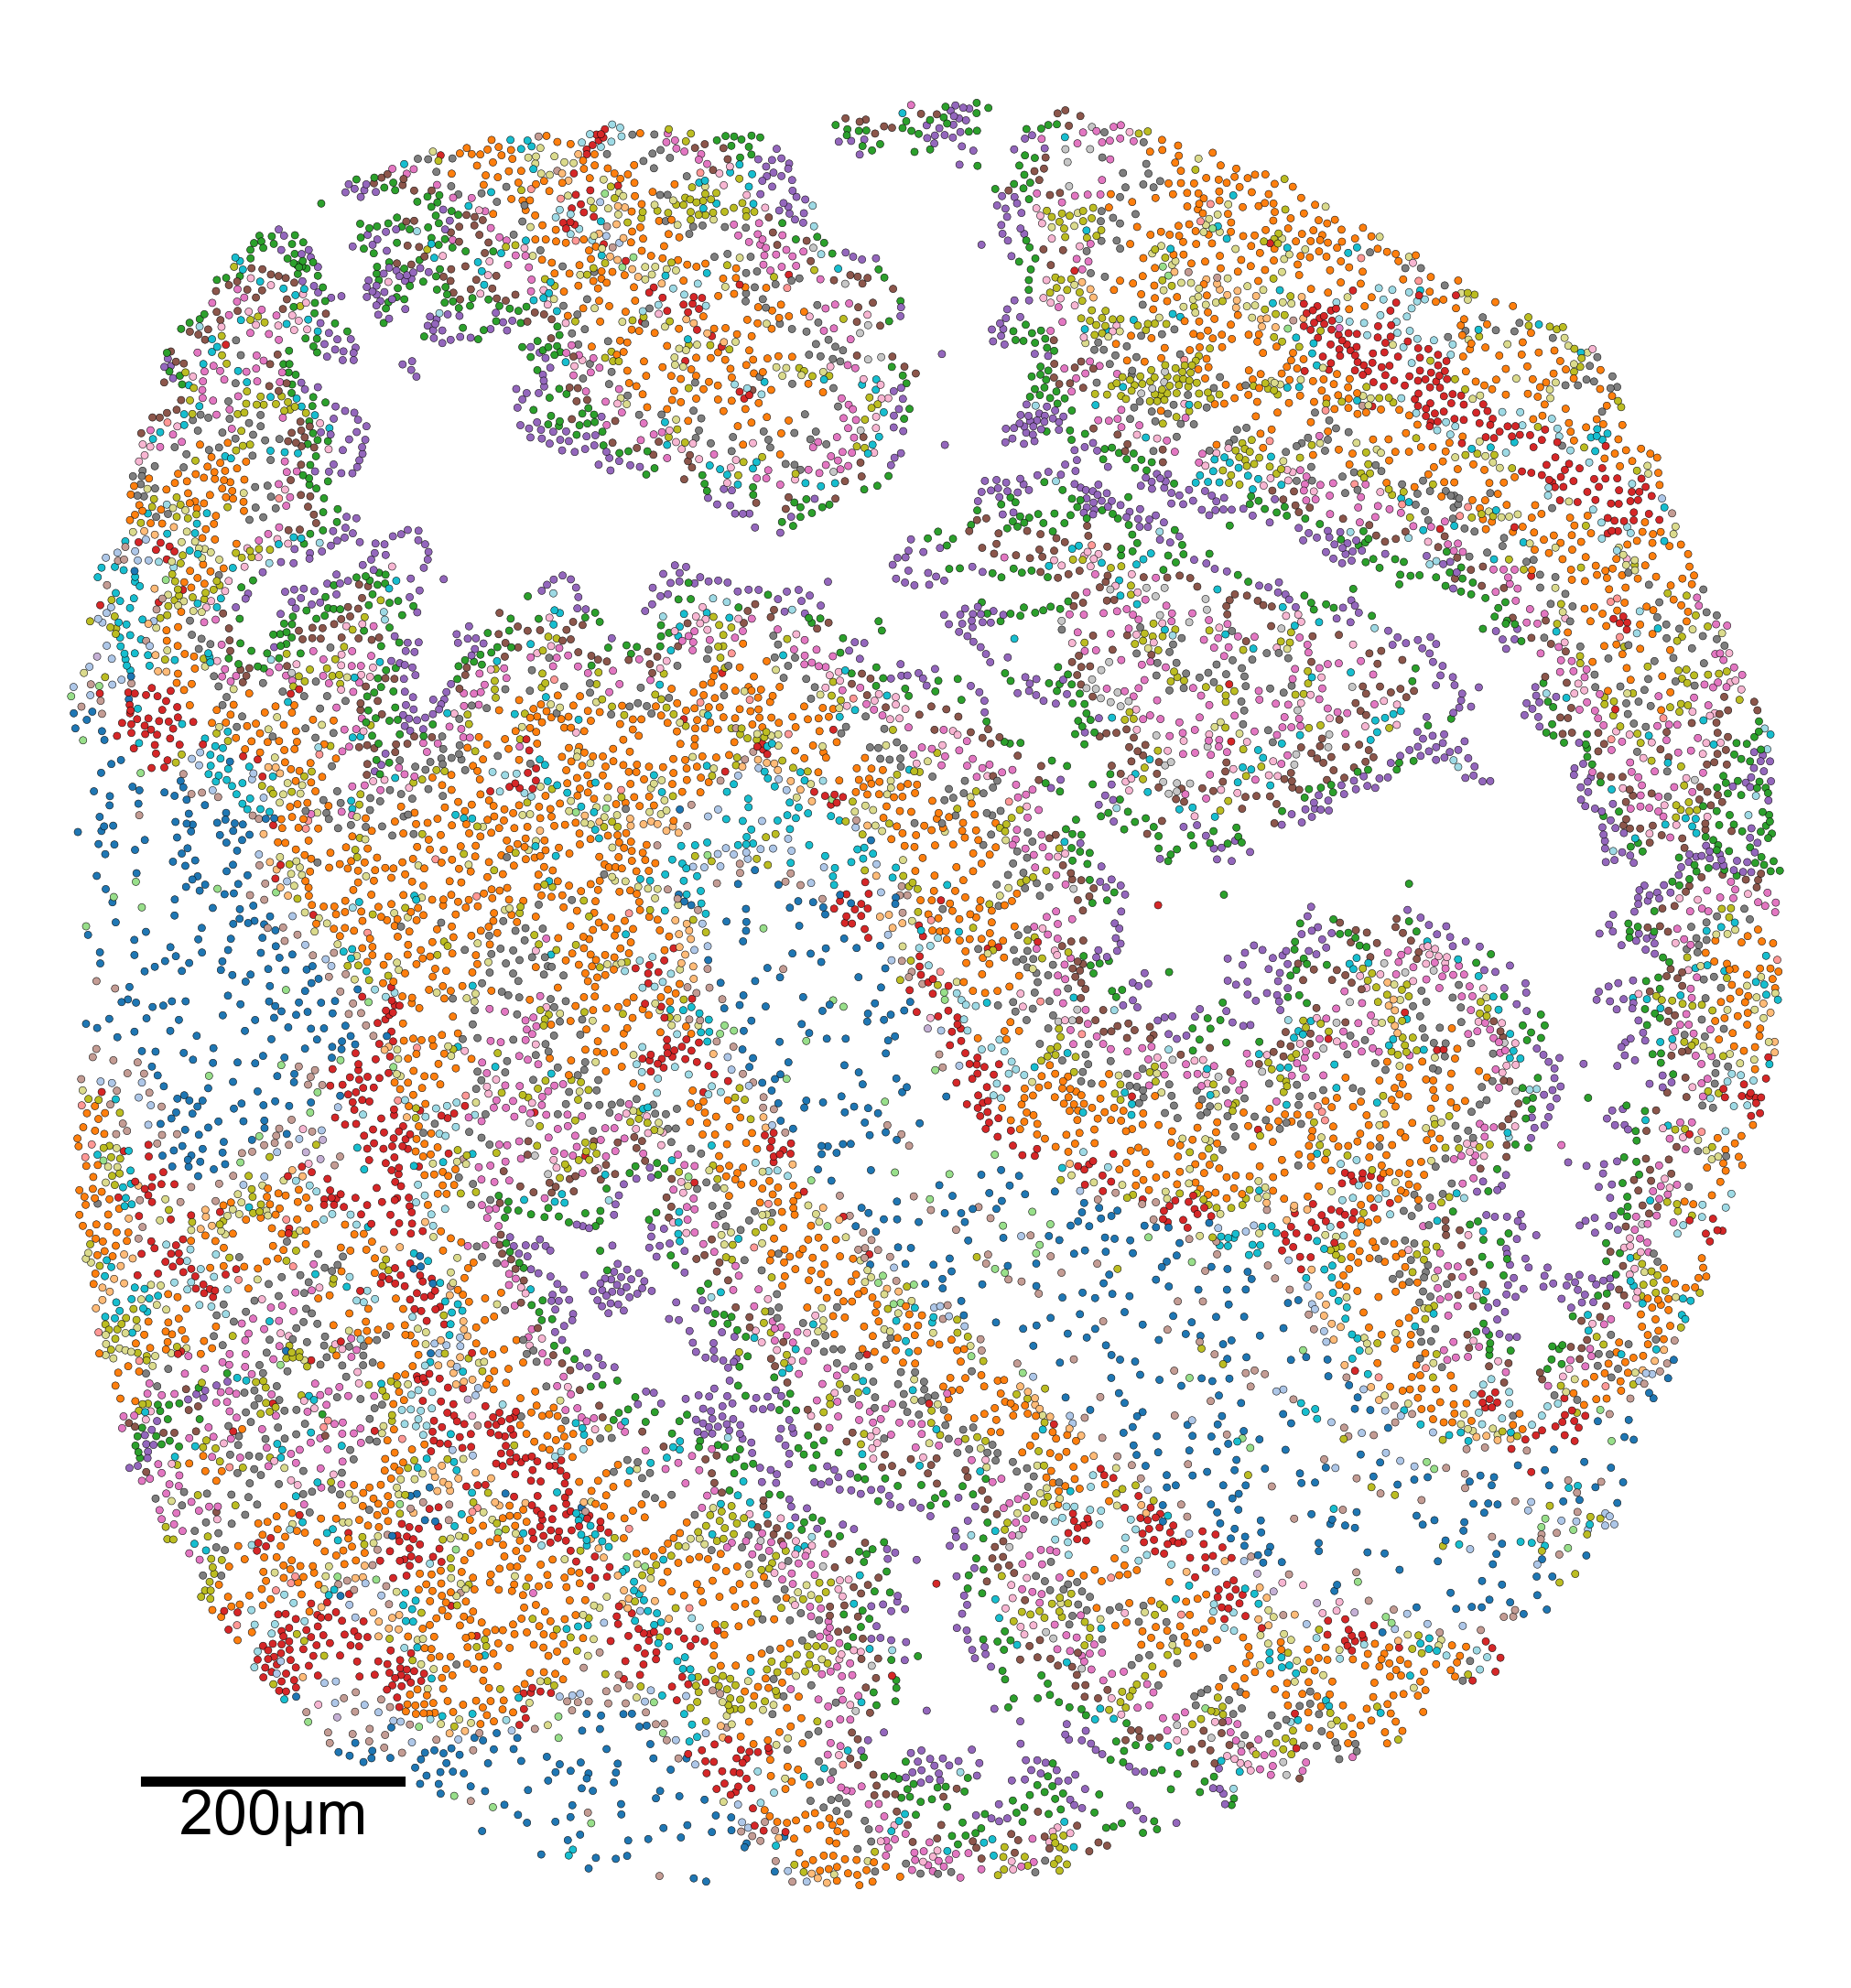

In [5]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(14, 15))

# Visualize the domain with cell centroids and cluster IDs
ms.visualise.visualise(
    domain_3,
    color_by=('label', 'Cluster ID'),
    marker_size=15,
    ax=ax,
    add_cbar=False,
    objects_to_plot=qPoints,
    scatter_kwargs={'edgecolor': 'black', 'linewidth': 0.25},
    shape_kwargs={'alpha': 0.2, 'linewidth': 0.1},
    add_scalebar=True,
    scalebar_kwargs=dict(
        size=200,
        label='200µm',
        loc='lower left',
        pad=2,
        color='black',
        frameon=False,
        size_vertical=6,
        fontproperties=fm.FontProperties(size=32)
    )
)

Text(0.5, 1.0, 'Estimated domain boundary')

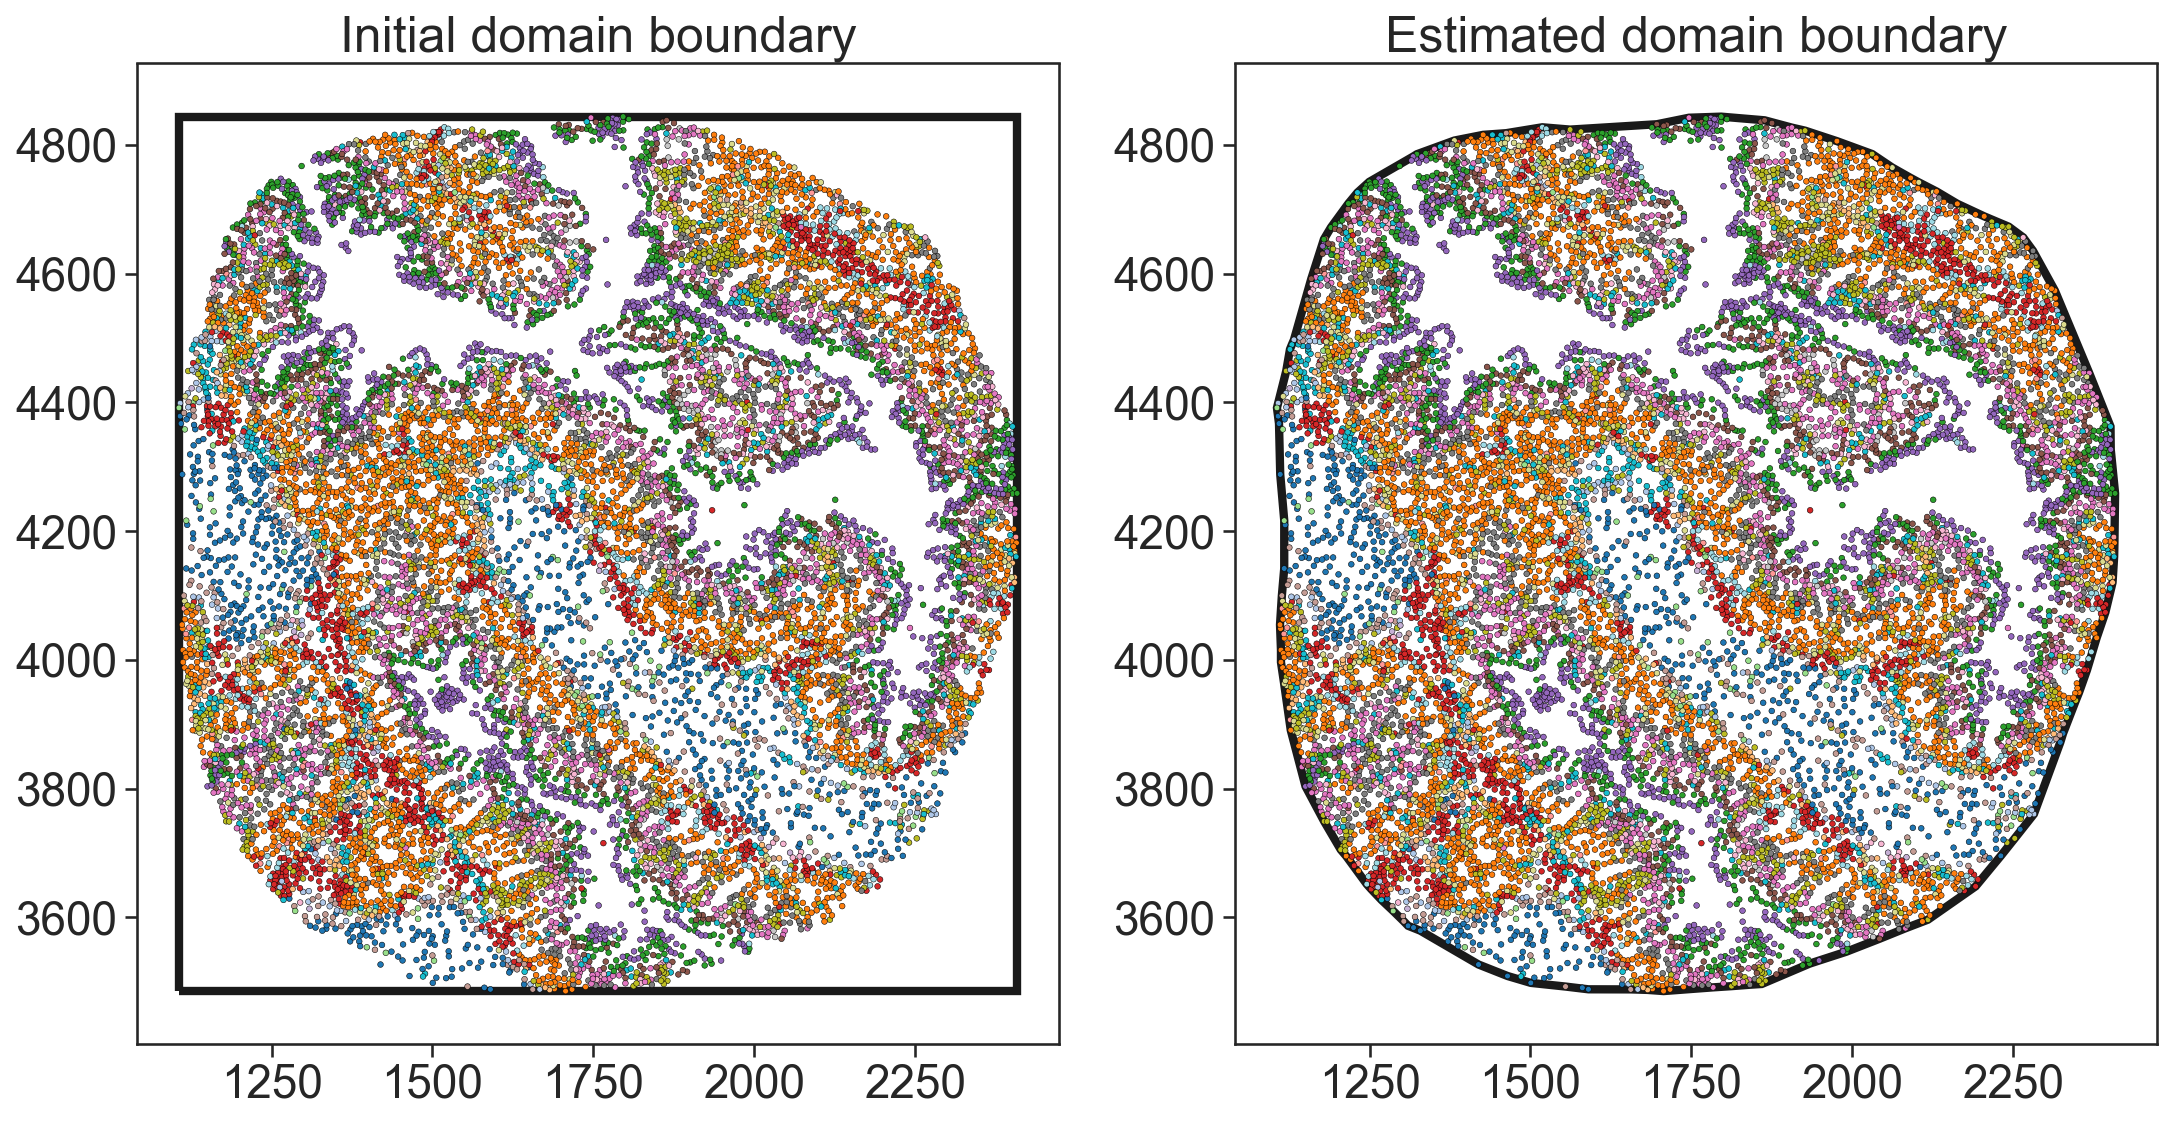

In [6]:
# Create a figure with 2 subplots side by side
fig, ax = plt.subplots(figsize=(15, 8), ncols=2, nrows=1)

# Visualize the initial domain boundary
ms.visualise.visualise(
    domain_3,
    color_by=('label', 'Cluster ID'),
    marker_size=7.5,
    ax=ax[0],
    add_cbar=False,
    objects_to_plot=qPoints,
    scatter_kwargs={'edgecolor': 'black', 'linewidth': 0.25},
    shape_kwargs={'alpha': 0.2, 'linewidth': 0.1},
    show_boundary=True
)
ax[0].set_title('Initial domain boundary')

# Estimate the domain boundary using the alpha shape method
domain_3.estimate_boundary(method='alpha shape', alpha_shape_kwargs=dict(alpha=400))

# Visualize the estimated domain boundary
ms.visualise.visualise(
    domain_3,
    color_by=('label', 'Cluster ID'),
    marker_size=7.5,
    ax=ax[1],
    add_cbar=False,
    objects_to_plot=qPoints,
    scatter_kwargs={'edgecolor': 'black', 'linewidth': 0.25},
    shape_kwargs={'alpha': 0.2, 'linewidth': 0.1},
    show_boundary=True
)
ax[1].set_title('Estimated domain boundary')

In [7]:
# Query the domain to get the cell centroids for Cluster 2 and Cluster 1
# This will be used for further spatial analysis

# Query for Cluster 2
q_2 = ms.query.query(domain_3, ('label', 'Cluster ID'), 'is', 'Cluster 2')

# Query for Cluster 1
q_1 = ms.query.query(domain_3, ('label', 'Cluster ID'), 'is', 'Cluster 1')

In [8]:
# Calculate the Pair Correlation Function (PCF) within the boundary for Cluster 1 and Cluster 2

# For Cluster 1 and Cluster 2
radii_inner_1_2, cross_PCF_1_2 = ms.spatial_statistics.cross_pair_correlation_function(
    domain_3,
    population_A=q_1,
    population_B=q_2,
    include_boundaries=None,
    max_R=265,
    annulus_step=5,
    annulus_width=15,
    exclude_zero=True,
    boundary_exclude_distance=20
)

# For Cluster 2 and Cluster 2
radii_inner_2_2, cross_PCF_2_2 = ms.spatial_statistics.cross_pair_correlation_function(
    domain_3,
    population_A=q_2,
    population_B=q_2,
    include_boundaries=None,
    max_R=265,
    annulus_step=5,
    annulus_width=15,
    exclude_zero=True,
    boundary_exclude_distance=20
)

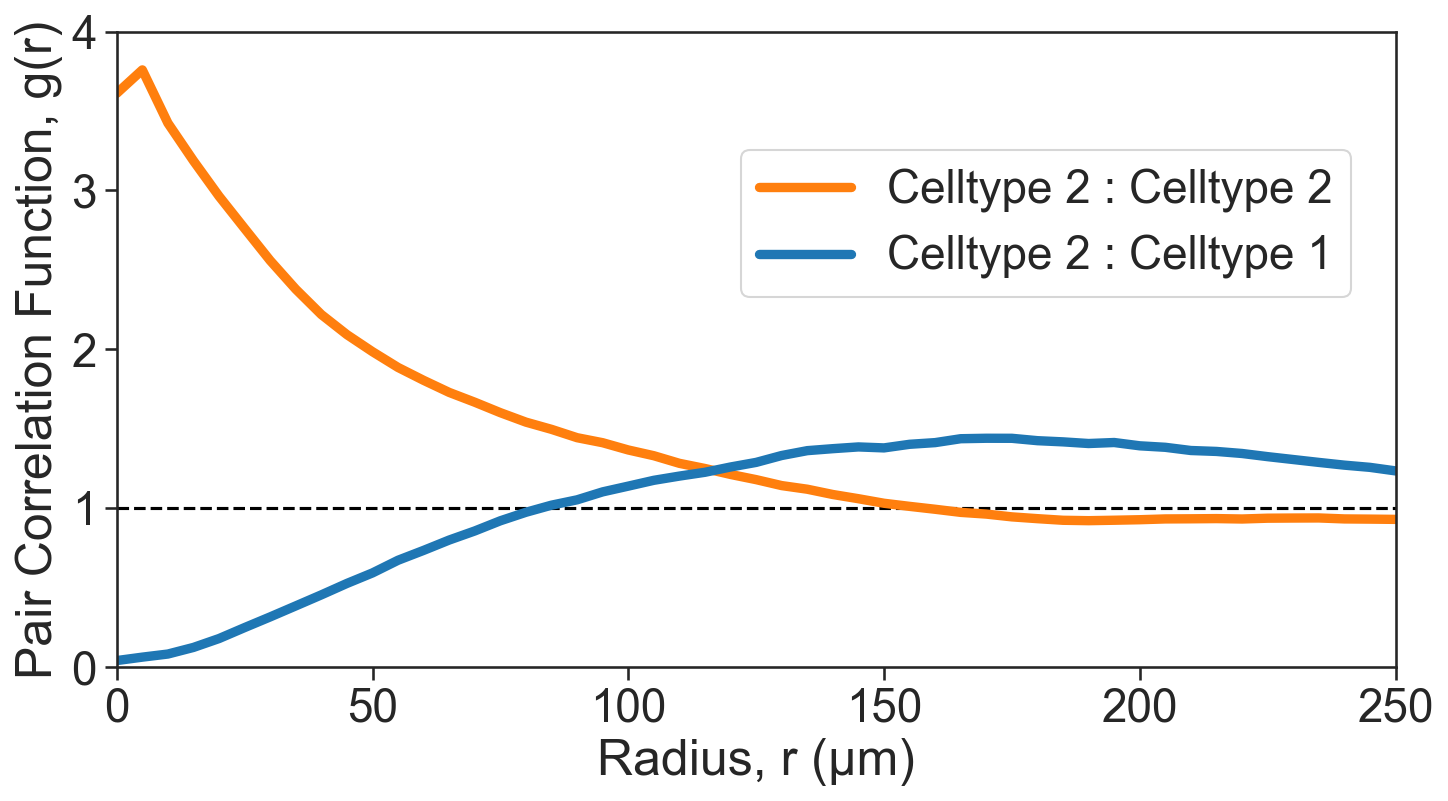

In [9]:
# Define clusters of interest
clusters_of_interest = ['Cluster 2', 'Cluster 5', 'Cluster 1']

# Get the color indices for the clusters of interest
color_indices = [np.where(domain_3.labels['Cluster ID']['categories'] == c)[0][0] for c in clusters_of_interest]

# Get the corresponding colors for the clusters of interest
these_cols = [sns.color_palette('tab20')[v] for v in color_indices]

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(11, 5.5))

# Add a horizontal line at y=1 for reference
ax.axhline(1, linestyle='--', color='black')

# Plot the Pair Correlation Function (PCF) 
sns.lineplot(x=radii_inner_2_2, y=cross_PCF_2_2, ax=ax, linewidth=4.5, label='Celltype 2 : Celltype 2', color=sns.color_palette('tab20')[2])
sns.lineplot(x=radii_inner_1_2, y=cross_PCF_1_2, ax=ax, linewidth=4.5, label='Celltype 2 : Celltype 1', color=sns.color_palette('tab20')[0])

# Axis tidying
ax.set_xlabel('Radius, r (µm)')
ax.set_ylabel('Pair Correlation Function, g(r)')
ax.set_xlim(0, 250)
ax.set_ylim(0, 4)
ax.set_xticklabels([0, 50, 100, 150, 200, 250])
ax.set_yticklabels([0, 1, 2, 3, 4])
ax.legend(loc='upper left', bbox_to_anchor=(0.47, 0.85))


In [10]:
# Perform Vietoris-Rips filtration on Cluster 2
# This will help us analyze the topological features of the cluster

# Vietoris-Rips filtration is a method used in topological data analysis to study the shape of data
# Here, we set the maximum dimension to 1 and the maximum distance to 250 micrometers

persistence_cluster_2 = ms.topology.vietoris_rips_filtration(
    domain_3,
    population=('Cluster ID', 'Cluster 2'),
    max_dimension=1,
    max_distance=250
)

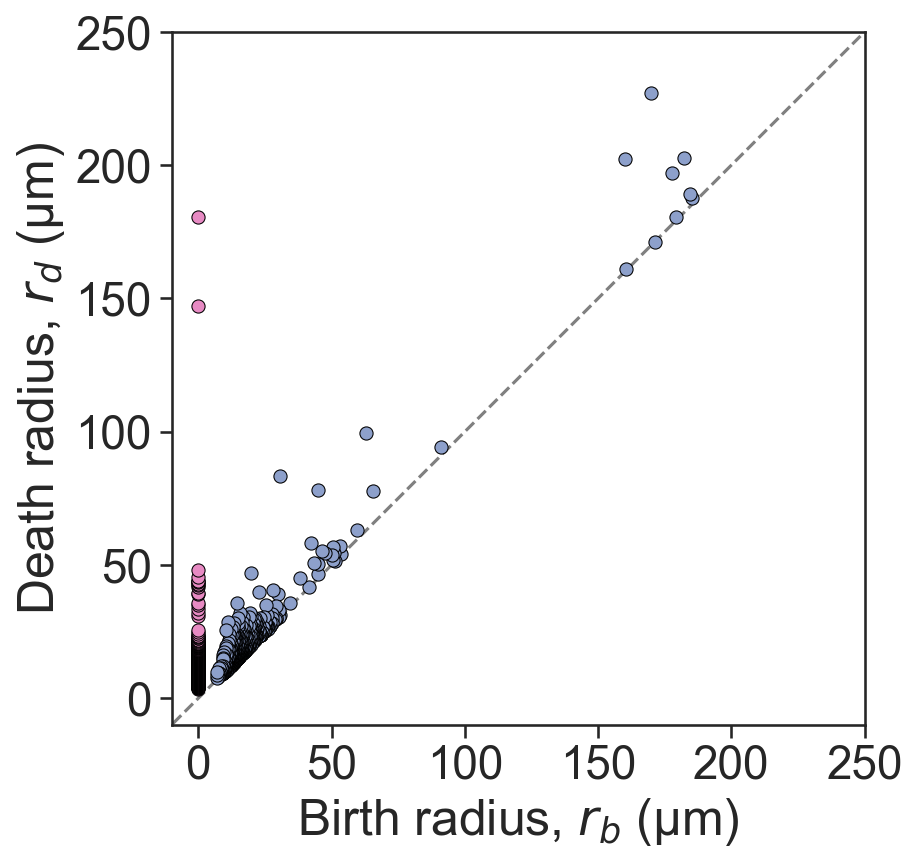

In [11]:
# Create a new figure and axis for plotting the persistence diagram
fig, ax = plt.subplots(figsize=(7.5, 6), nrows=1, ncols=1)

# Plot a reference line
ax.plot([-1000, 1000], [-1000, 1000], linestyle='--', color='grey', zorder=0)

# Scatter plot for 0-dimensional persistence points
sns.scatterplot(
    x=persistence_cluster_2['dgms'][0][:, 0],
    y=persistence_cluster_2['dgms'][0][:, 1],
    ax=ax,
    color=sns.color_palette('Set2')[3],
    s=40,
    edgecolor='black'
)

# Scatter plot for 1-dimensional persistence points
sns.scatterplot(
    x=persistence_cluster_2['dgms'][1][:, 0],
    y=persistence_cluster_2['dgms'][1][:, 1],
    ax=ax,
    color=sns.color_palette('Set2')[2],
    s=40,
    edgecolor='black'
)

# Axis tidying
ax.set_xlabel('Birth radius, $r_{b}$ (µm)')
ax.set_ylabel('Death radius, $r_{d}$ (µm)')
ax.set_aspect('equal')
ax.set_xlim(-10, 250)
ax.set_ylim(-10, 250)
ax.set_xticks([0, 50, 100, 150, 200, 250])
ax.set_yticks([0, 50, 100, 150, 200, 250])

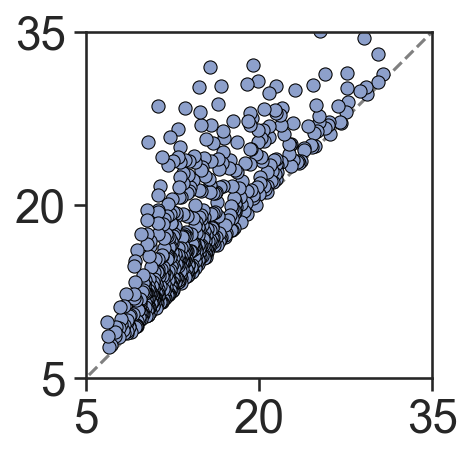

In [12]:
# Create a new figure and axis for plotting the persistence diagram
fig, ax = plt.subplots(figsize=(3, 3), nrows=1, ncols=1)

# Plot a reference line
ax.plot([-1000, 1000], [-1000, 1000], linestyle='--', color='grey', zorder=0)

# Scatter plot for 0-dimensional persistence points
sns.scatterplot(
    x=persistence_cluster_2['dgms'][0][:, 0],
    y=persistence_cluster_2['dgms'][0][:, 1],
    ax=ax,
    color=sns.color_palette('Set2')[3],
    s=40,
    edgecolor='black'
)

# Scatter plot for 1-dimensional persistence points
sns.scatterplot(
    x=persistence_cluster_2['dgms'][1][:, 0],
    y=persistence_cluster_2['dgms'][1][:, 1],
    ax=ax,
    color=sns.color_palette('Set2')[2],
    s=40,
    edgecolor='black'
)

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal')

# Set the limits for the x and y axis
ax.set_xlim(5, 35)
ax.set_ylim(5, 35)

# Set the ticks for the x and y axis
ax.set_xticks([5, 20, 35])
ax.set_yticks([5, 20, 35])